# L2 & L3 snapshots fast sampling phase 

In [1]:
import os, sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import xarray as xr
import datetime

import matplotlib.pyplot as plt
#import cartopy
#crs = cartopy.crs.PlateCarree()
#import cartopy.feature as cfeature

import hvplot.xarray
import hvplot.pandas

import pyinterp
import swot_calval.io

sys.path.append("/work/HELPDESK_SWOTLR/swot_diego/libs")
import swot_diego as sd
crs = sd.crs

In [2]:
client, cluster = sd.spin_up_cluster(jobs=2, memory='16GiB', walltime='04:00:00')
#cores=1,
#memory='8GiB', # Balanced configuration should have 8 GiB per core if possible
#cluster.scale(jobs=4)

In [3]:
cluster

Dashboard: /user/pontea/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.11.2.169:38763,Workers: 0
Dashboard: /user/pontea/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---

## utils

```
len(collection.variables()) # 
list(collection.half_orbits())[:5] # acquired passes
list(collection.cycles())[:5] # acquired cycles
collection.period() # first/last partition entry
collection.half_orbit_periods() # half orbit periods
pandas.DataFrame(collection.half_orbit_periods()) # Convert the ORF as a pandas.DataFrame
```

---
## load data

In [4]:
#sd.load_l2(probe_variables=True)
#sd.load_l3(probe_variables=True)

In [5]:
#region = "med_NW_CN"
#region = "med_NW"
region = "maluku"
info = sd.regions[region]

# get passes
#times = sd.get_passes_times(info["coordinates"])

# selected variables
#SSH = ['ssha_karin_2_filtered', 'mean_sea_surface_cnescls', 'cvl_mean_dynamic_topography_cnes_cls_22', 'xcal']
#UV = ['speed_zonal', 'speed_meridional', 'speed_zonal_abs', 'speed_meridional_abs']
#SIG0 = ['sig0_karin_2']
l3_variables = sd.l3["ssh"]+sd.l3["speed"]+sd.l3["sig0"]

half_orbits = sd.load_l3(
    pass_numbers=info["passes"],
    variables=l3_variables,
    first_day=datetime.date(2023, 4, 1),
    last_day=datetime.date(2023, 7, 15),
    geoselection = info['coordinates'],
)

In [6]:
# load wind
location = info["location"]
era5 = sd.load_era5("2023/03/15", "2023/08/01", location=location)

In [6]:
#for (cycle, pass_number), ds in half_orbits.items():
#    # ds = ds.to_xarray()
#    #print(cycle, pass_number, ds.dimensions)
#    pass

```
tuple(half_orbits.keys()) # Print each half-orbit loaded
dict(half_orbits) # Get the dictionary between half-orbits and datasets
half_orbits[(509, 20)] # Retrieve the dataset for a specific half-orbit
```

---

## dev on a snapshot

In [40]:
# transects
tr = dict(
    t0=dict(lon=[126.5, 124.5], lat=[-1.7, 1.5]),
    t1=dict(lon=[126.5, 125], lat=[-1.7, 1.5]),
    t2=dict(lon=[126.5, 125.5], lat=[-1.7, 2.]),
)

In [7]:
# run once to get local projection parameters

cycle = 510
pass_number = info["passes"][0]
zds = half_orbits[(cycle, pass_number)]
ds = zds.to_xarray().persist()

v, level = 'ssh', 'L3'
da, t_min, t_max = sd.load_swot_da(
    zds, v, level=level, 
    extent=info['extent'], geoselection=info["coordinates"], project=True,
)
gproj = {k: da.attrs[k] for k in ["lonc", "latc", "phi"]}

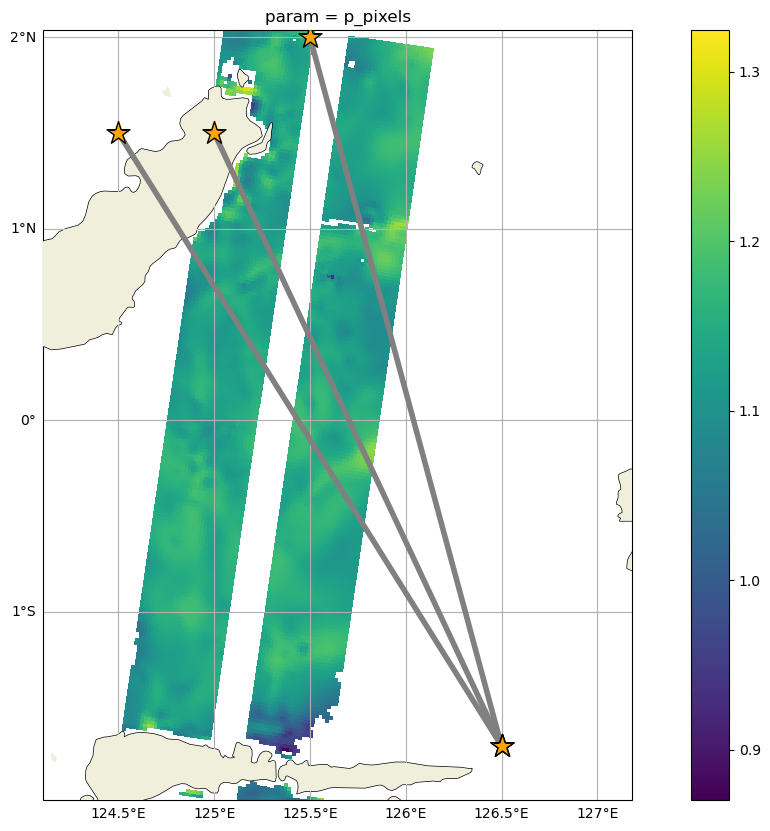

In [8]:
fig, ax = sd.plot_map(info["extent"])

da.plot(x="longitude", y="latitude", ax=ax, transform=crs, center=False) #, cmap="Greys_r", center=False, vmax=200)

for label, t in tr.items():
    lon, lat = t["lon"], t["lat"]
    ax.scatter(lon, lat, s=300, zorder=10, marker="*", c="orange", edgecolor="k")
    ax.plot(lon, lat, color="0.5", lw=4, zorder=9)

In [8]:
from scipy.interpolate import griddata

def lonlat2xy(lon, lat):
    lonc, latc, phi = (gproj[k] for k in ["lonc", "latc", "phi"])
    x, y = sd._lonlat2xy(lonc, latc, phi, lon, lat)
    x = x/1e3
    y = y/1e3
    return x, y


def slice_data_core(da, tr, v=None, delta_s=0.1):

    if v is None:
        v="some_variable"
    
    if isinstance(da, dict):
        # L2
        ds = slice_data_core(da["left"], tr, v=v, delta_s=delta_s)
        right = slice_data_core(da["right"], tr, v=v, delta_s=delta_s)
        ds[v] = ds[v].where(~np.isnan(ds[v]), other=right[v])
        return ds
    
    lon, lat = np.array(tr["lon"]), np.array(tr["lat"])
    
    # compute local projection of the transect
    x, y = lonlat2xy(lon, lat)

    # build transect coordinates
    n = int(np.sqrt((x[1]-x[0])**2+(y[1]-y[0])**2)/delta_s)
    #print(f"{n} points")
    xs = np.linspace(x[0], x[1], n)
    ys = np.linspace(y[0], y[1], n)
    lons = np.linspace(lon[0], lon[1], n)
    lats = np.linspace(lat[0], lat[1], n)
    s = np.sqrt((xs-xs[0])**2+(ys-ys[0])**2) # km
    
    # interpolate data
    da_i = griddata(
        (da.x.values.flatten(), da.y.values.flatten()), da.values.flatten(), 
        (xs, ys), 
        method='linear',
    )

    # store in dataset
    ds_i = xr.Dataset(
        {v: ("s", da_i)},
        coords = dict(
            s=s, 
            longitude=("s", lons), 
            latitude=("s", lats),
        ),
    )
    
    return ds_i

def slice_data(v, level, tr, **kwargs):
    """ loop over transects and low all data """

    D = {key: [] for key in tr}
    i=-1
    for (cycle, pass_number), zds in tqdm(half_orbits.items()):
        i+=1
        #if i<20:
        #    print(i)
        #    continue
        out = sd.load_swot_da(
            zds, v, level=level, 
            extent=info['extent'], geoselection=info["coordinates"], project=gproj,
            **kwargs,
        )
        if out is not None:
            da, t_min, t_max = out
            for key, t in tr.items():
                ds = slice_data_core(da, t, v=v)
                ds["time"] = t_min
                ds["cycle"] = cycle
                ds["pass"] = pass_number
                D[key].append(ds)
        else:
            print(f"None at iteration {i}")
    
    # zoom along valid s
    for key, d in D.items():
        ds = xr.concat(d, "time")
        _s = ds[v].dropna("s", how="all").s
        s0, s1 = (float(_s[i]) for i in [0, -1])
        ds = ds.sel(s=slice(s0,s1))
        D[key] = ds
    
    return D

In [9]:
# dev

# L3
#slice_data_core(da, tr["t0"], v=v)

#v, level = 'ssh', 'L2_unsmoothed_std'
#da, t_min, t_max = sd.load_swot_da(
#    zds, v, level=level, 
#    extent=info['extent'], geoselection=info["coordinates"], project=True,
#)
#ds = slice_data_core(da, tr["t0"], v=v)

In [10]:
# prod
v, level = 'ssh', 'L3'
#v, level = 'sig0', 'L3'
#v, level = 'ssh', 'L2_unsmoothed_std'
#v, level = 'sig0', 'L2_unsmoothed_std'

D = slice_data(v, level, tr)

# store data
for key, ds in D.items():
    nc = os.path.join(sd.root_path, f"diags/{region}_{v}_{level}_{key}.nc")
    print(nc)
    ds.to_netcdf(nc, mode="w")

81it [02:19,  1.73s/it]


/work/HELPDESK_SWOTLR/swot_diego/diags/maluku_ssh_L3_t0_tmp.nc
/work/HELPDESK_SWOTLR/swot_diego/diags/maluku_ssh_L3_t1_tmp.nc
/work/HELPDESK_SWOTLR/swot_diego/diags/maluku_ssh_L3_t2_tmp.nc


---
## reload and plot

In [9]:
def load_tr(level):

    D = {}
    for key in tr:
        _D = []
        for v in ["ssh", "sig0"]:
            _D.append(
                xr.open_dataset(os.path.join(sd.root_path, f"diags/{region}_{v}_{level}_{key}.nc"))
            )
        D[key] = xr.merge(_D)
    
    return D

In [10]:
L3 = load_tr("L3")
L2 = load_tr("L2_unsmoothed_std")

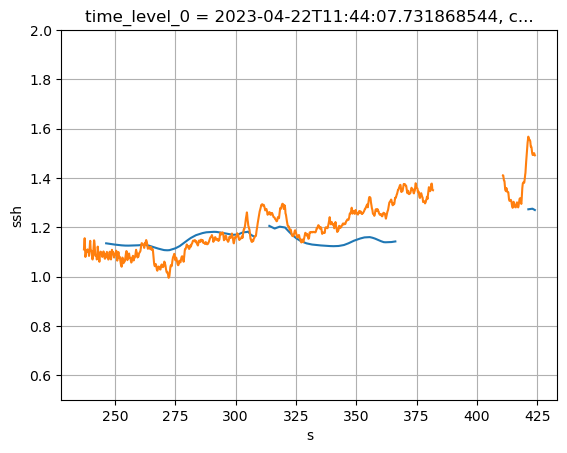

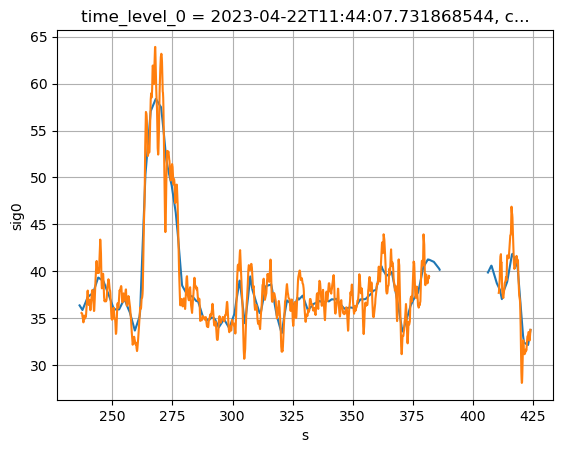

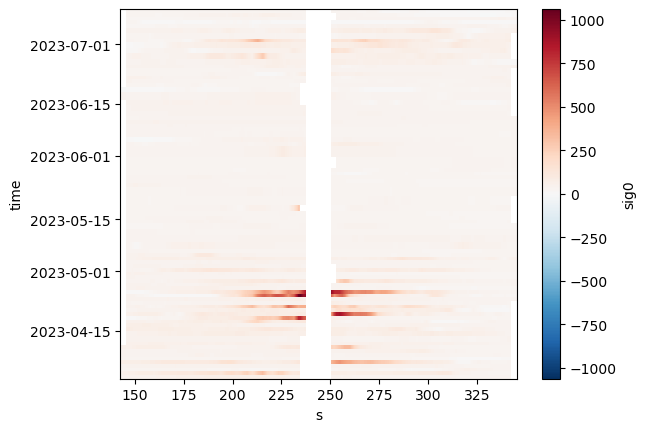

In [54]:
L3["t0"].sig0.plot()

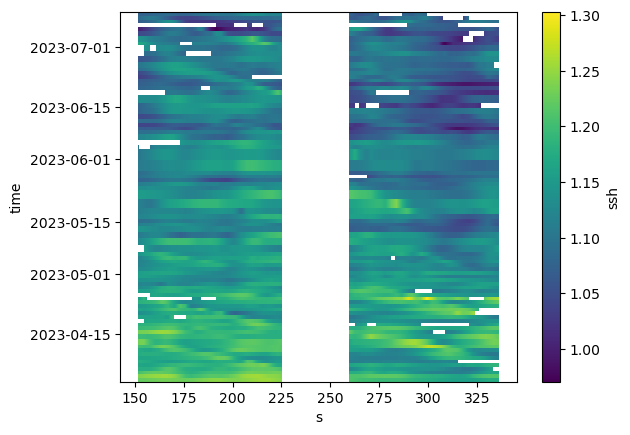

In [47]:
L3["t0"].ssh.plot()

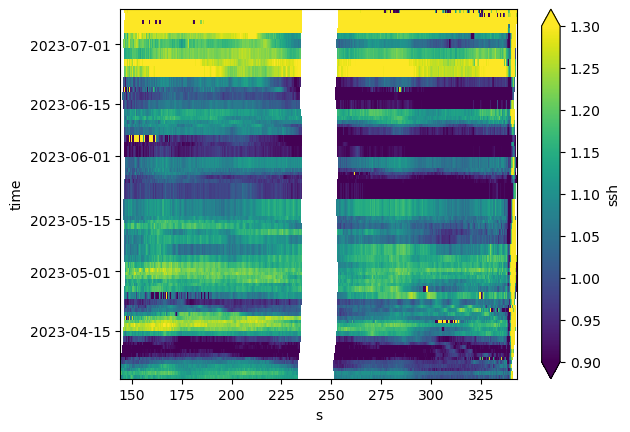

In [50]:
L2["t0"].ssh.plot(vmin=.9, vmax=1.3)

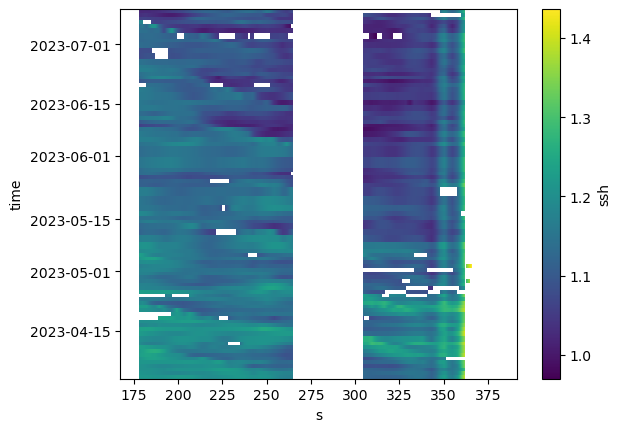

In [48]:
L3["t1"].ssh.plot()

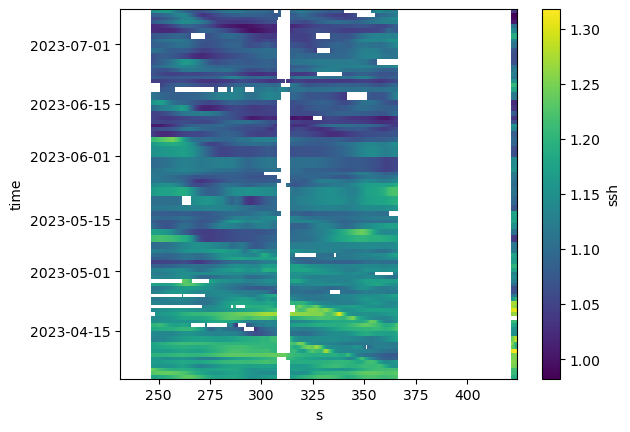

In [51]:
L3["t2"].ssh.plot()

In [53]:
# run once to get local projection parameters


def load_v(v, cycle):

    pass_number = info["passes"][0]
    zds = half_orbits[(cycle, pass_number)]
    
    level = 'L3'
    l2, t_min, t_max = sd.load_swot_da(
        zds, v, level=level, 
        extent=info['extent'], geoselection=info["coordinates"], project=gproj,
    )

    level = 'L2_unsmoothed_std'
    l2, t_min, t_max = sd.load_swot_da(
        zds, v, level=level, 
        extent=info['extent'], geoselection=info["coordinates"], project=gproj,
    )
    
    return l2, l3

In [83]:
def plot_l2(l2, v, **kwargs):

    if v=="ssh":
        kw = dict(vmin=.9, vmax=1.4, cmap='RdYlBu_r', transform=crs)
    elif v=="sig0":
        kw = dict(vmin=-5, vmax=30, cmap='Greys_r', transform=crs)
    kw.update(**kwargs)

    fig, ax = sd.plot_map(info["extent"])

    da = l2["left"]
    im = ax.scatter(
        x=da.longitude, y=da.latitude, c=da, s=.1,
        **kw,
    )

    da = l2["right"]
    im = ax.scatter(
        x=da.longitude, y=da.latitude, c=da, s=.1,
        **kw,
    )

    fig.colorbar(im, ax=ax)

    for label, t in tr.items():
        lon, lat = t["lon"], t["lat"]
        ax.scatter(lon, lat, s=300, zorder=10, marker="*", c="orange", edgecolor="k")
        ax.plot(lon, lat, color="0.5", lw=4, zorder=9)
        

def plot_transects(cycle, t, ssh=(.9,1.6), sig0=(0,60)):

    l3 = L3[t].set_index(dict(time="cycle"), append=True).sel(cycle=cycle)
    #t = l3.time.values

    l2 = L2[t].set_index(dict(time="cycle"), append=True).sel(cycle=cycle)
    #l2 = L2[tr].sel(time=t, method="nearest")


    fig, axes = plt.subplots(2,1, sharex=True)

    ax = axes[0]
    l3.ssh.plot(ax=ax, color="cadetblue", lw=3)
    l2.ssh.plot(ax=ax, color="k")
    ax.set_ylim(*ssh)
    ax.grid()
    ax.set_title("ssh")
    ax.set_xlabel("")

    ax = axes[1]
    l3.sig0.plot(ax=ax, color="cadetblue", lw=3)
    l2.sig0.plot(ax=ax, color="k")
    ax.set_ylim(*sig0)
    ax.grid()
    ax.set_title(r"$σ_0$")

---

In [104]:
cycle = 498

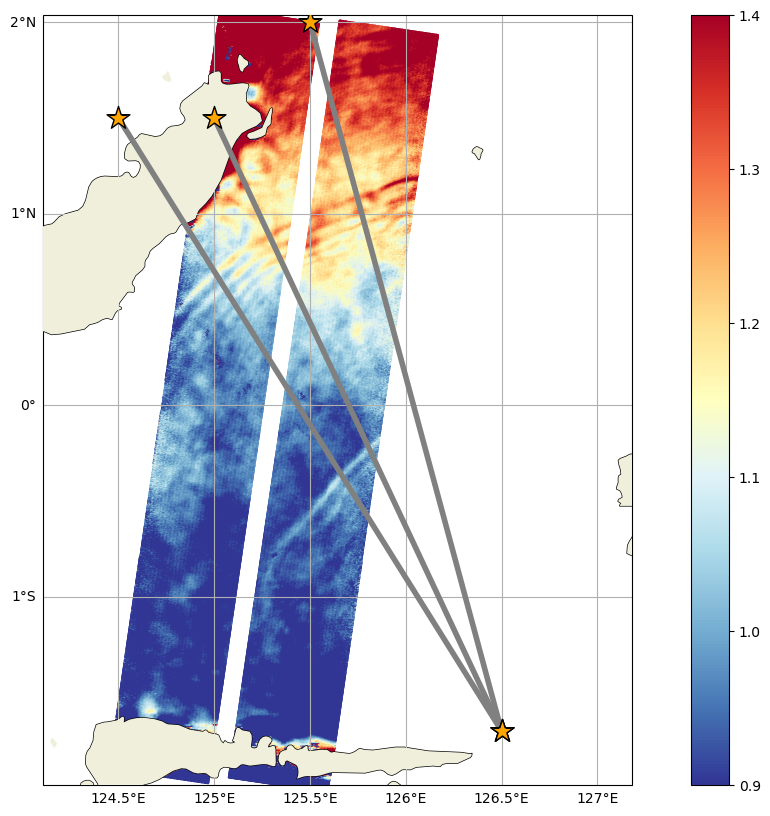

In [62]:
v = "ssh"
l2, l3 = load_v(v, cycle)

plot_l2(l2, v)

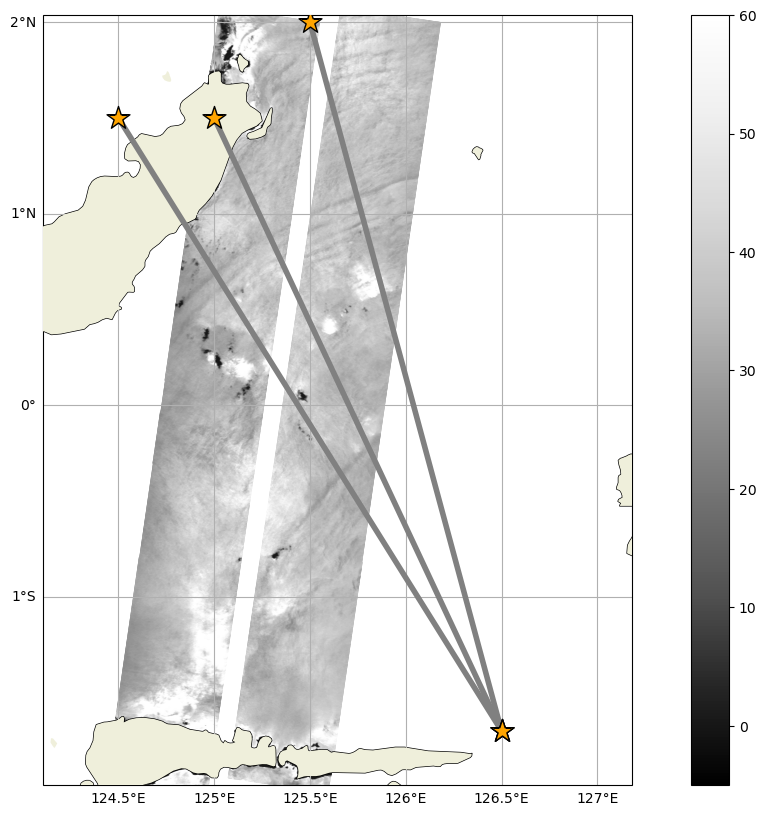

In [64]:
v = "sig0"
l2, l3 = load_v(v, cycle)

plot_l2(l2, v, vmax=60)

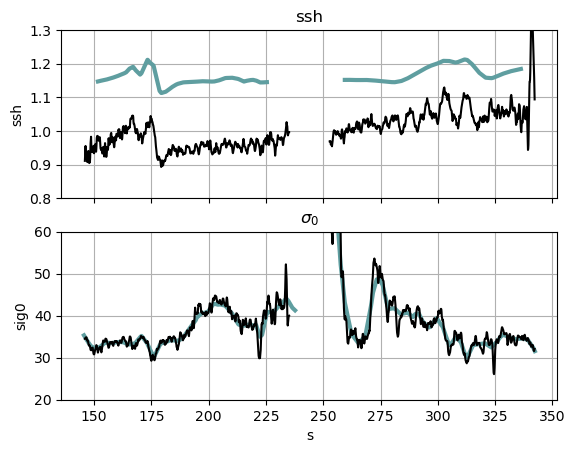

In [108]:
plot_transects(cycle, "t0", ssh=(.8,1.3), sig0=(20,60))

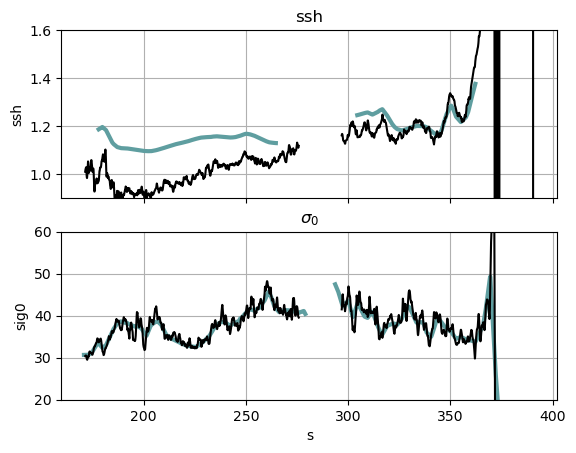

In [109]:
plot_transects(cycle, "t1", sig0=(20,60))

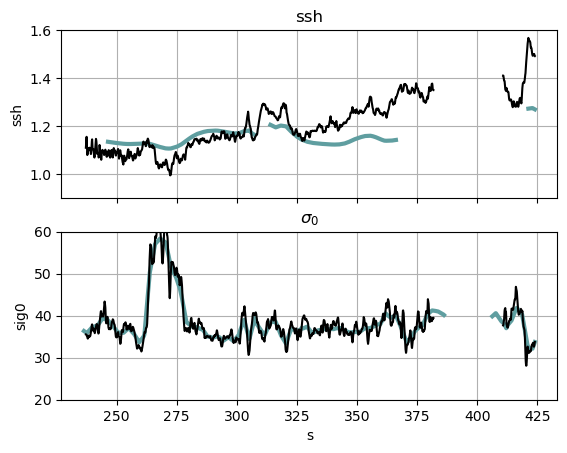

In [112]:
plot_transects(cycle, "t2", sig0=(20,60))

In [113]:
#for t in tr:
#    plot_transects(cycle, t)

---

In [114]:
cycle = 496

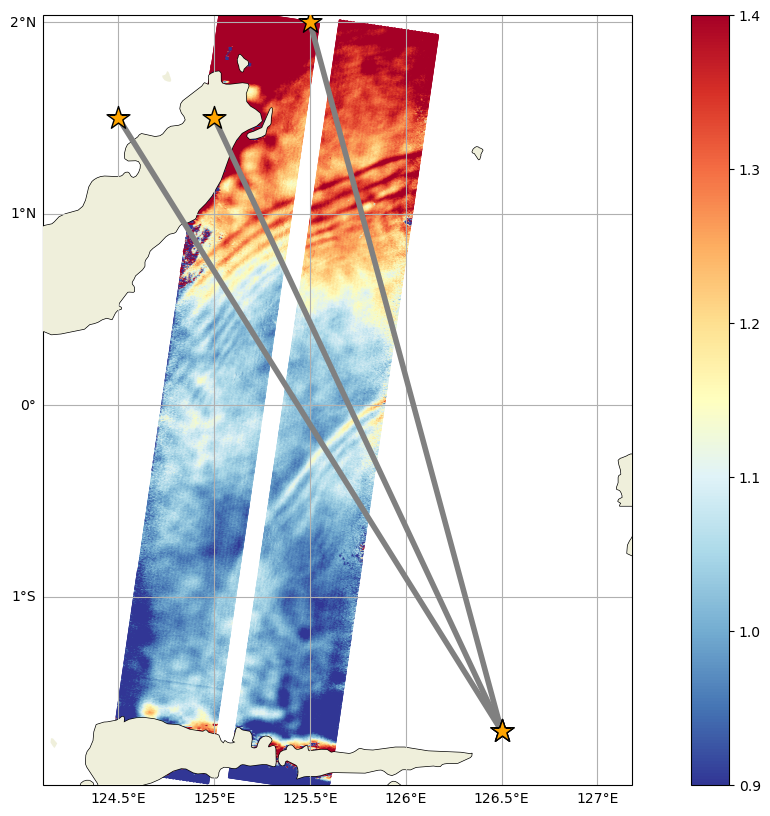

In [86]:
v = "ssh"
l2, l3 = load_v(v, cycle)
plot_l2(l2, v)

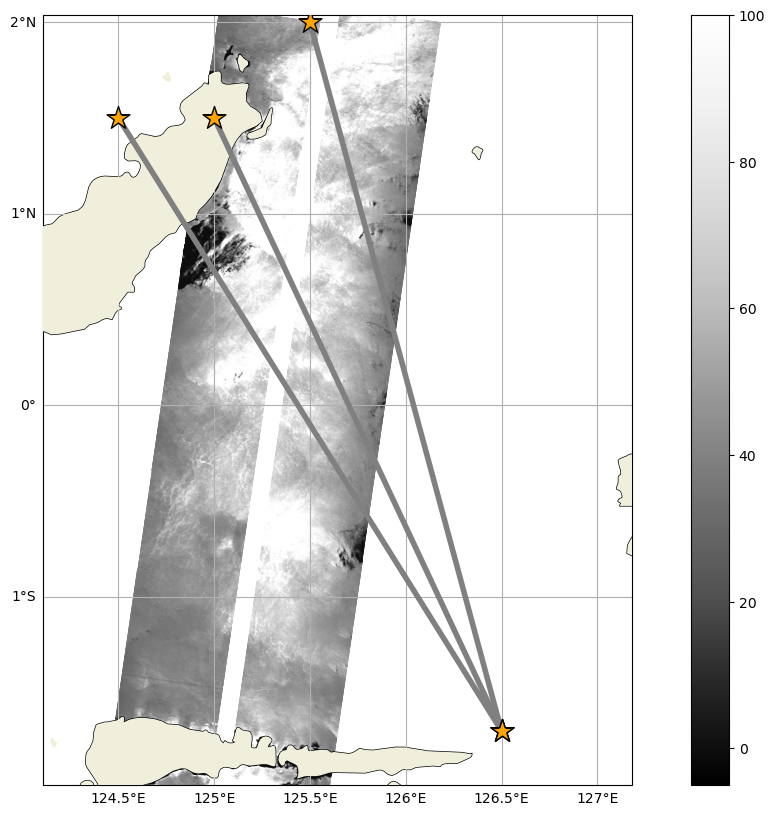

In [89]:
v = "sig0"
l2, l3 = load_v(v, cycle)
plot_l2(l2, v, vmax=100)

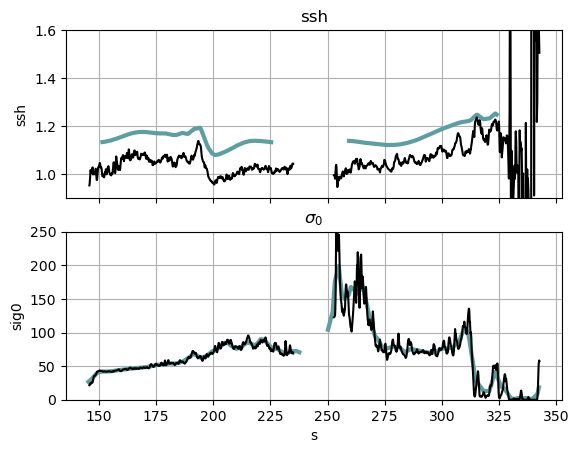

In [97]:
plot_transects(cycle, "t0", sig0=(0,250))

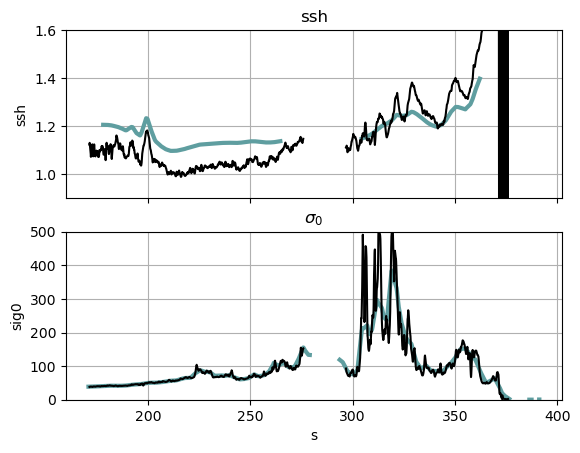

In [100]:
plot_transects(cycle, "t1", sig0=(0,500))

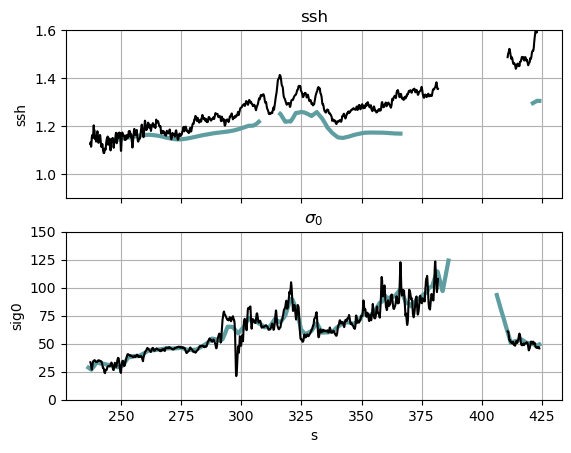

In [102]:
plot_transects(cycle, "t2", sig0=(0,150))

---

In [117]:
cycle = 512

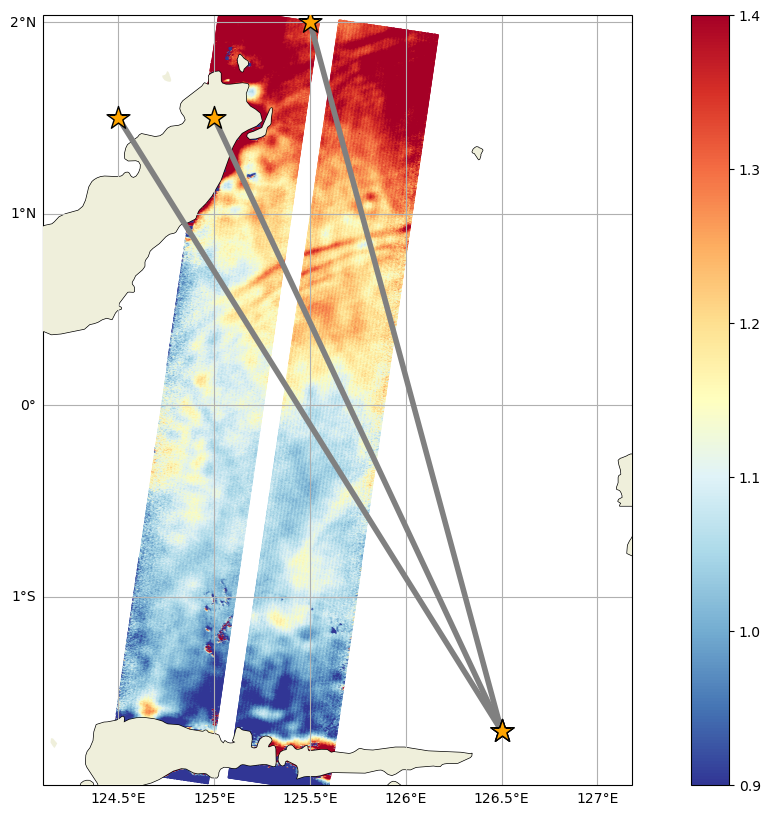

In [80]:
v = "ssh"
l2, l3 = load_v(v, cycle)
plot_l2(l2, v)

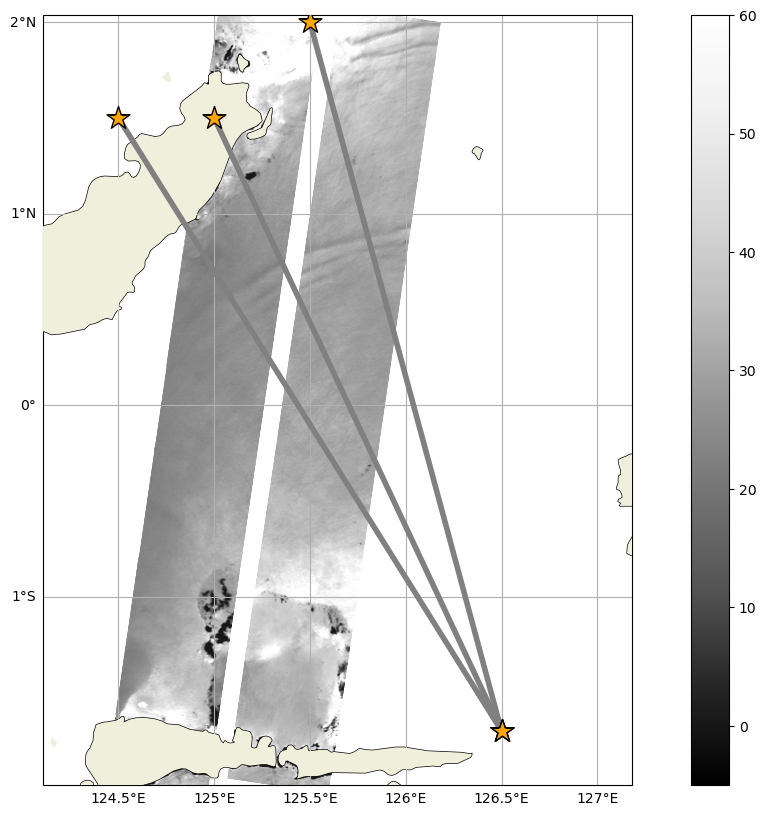

In [81]:
v = "sig0"
l2, l3 = load_v(v, cycle)
plot_l2(l2, v, vmax=60)

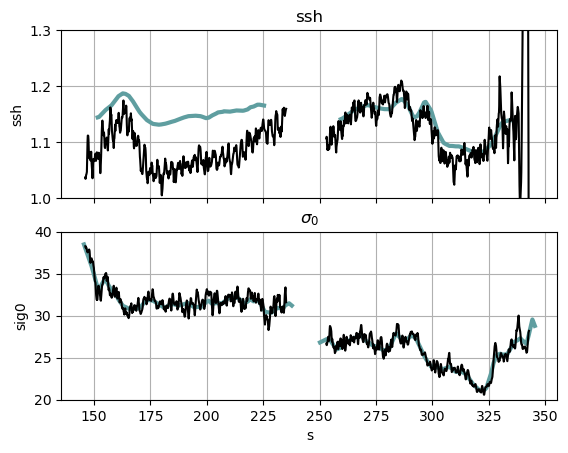

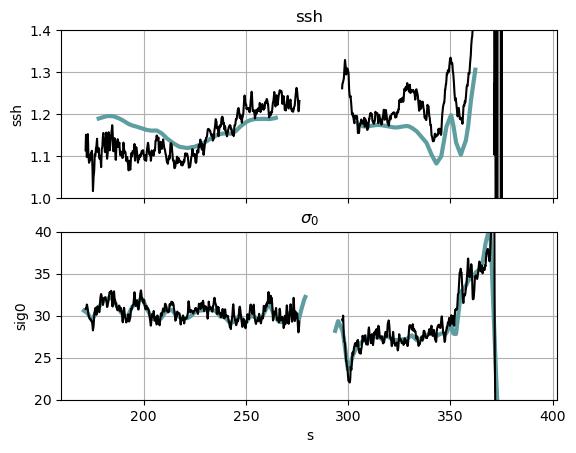

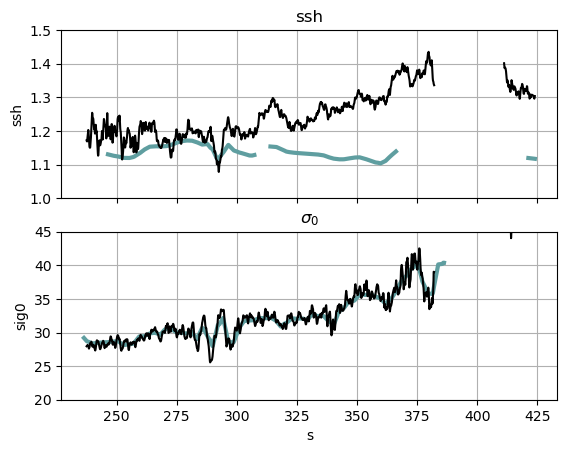

In [118]:
plot_transects(cycle, "t0", ssh=(1.,1.3), sig0=(20,40))
plot_transects(cycle, "t1", ssh=(1.,1.4), sig0=(20,40))
plot_transects(cycle, "t2", ssh=(1.,1.5), sig0=(20,45))

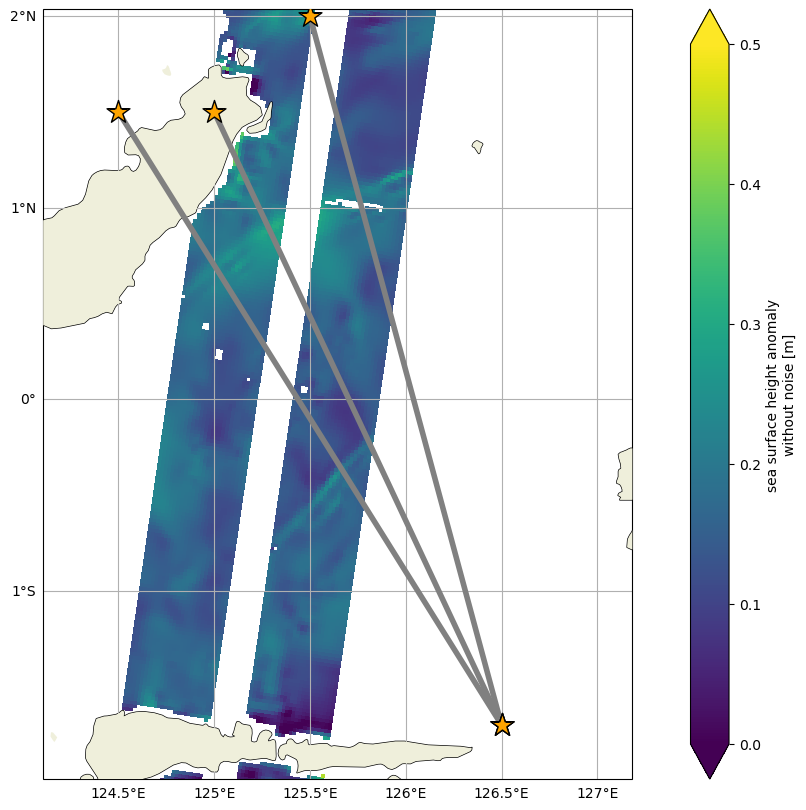

In [46]:
fig, ax = sd.plot_map(info["extent"])

l3.ssha_karin_2_filtered.plot(
    x="longitude", y="latitude", ax=ax, transform=crs, center=False,
    vmin=0., vmax=.5,
)

for label, t in tr.items():
    lon, lat = t["lon"], t["lat"]
    ax.scatter(lon, lat, s=300, zorder=10, marker="*", c="orange", edgecolor="k")
    ax.plot(lon, lat, color="0.5", lw=4, zorder=9)

---

In [ ]:
client.close()
cluster.close()